## <strong> ConvNet Configurations </strong>

<h3> <strong> 1. Architecture </strong> </h3>

* input image: **224 × 224 RGM Image** (전처리로 traininig set의 각 pixel에 평균 RGB 값을 빼준다.)
* ConvNet kernel size: **3 × 3 filter, padding & stride: 1**
* 비선형을 위한 kernel size : **1 × 1 filter** / can be seen linear transformation
* pooling: **Max-pooling / 2 × 2 filter, stride: 2**
* FC Layer: **3개의 FC Layer**를 가지고 있으며 첫 번째와 두 번째 FC는 4096 channel, 세 번째 FC는 1000 channel을 가진다.
* Activation Function: **ReLU**
* LRN(Local Response Normalization)은 사용하지 않는다.

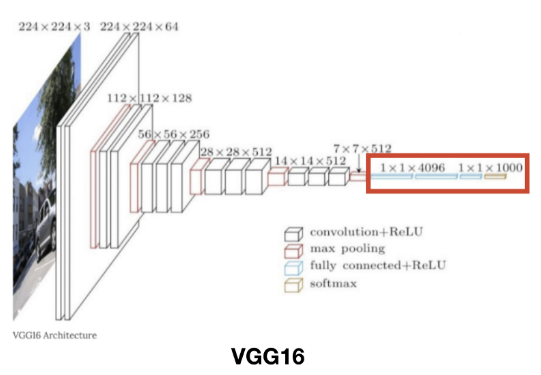

<h3> <strong> 2. Configurations </strong> </h3>

실험에 사용한 모델은 아래와 같다. <br>
층은 11~19 까지 깊이로 실험되었고 channel은 512까지 도달한다.

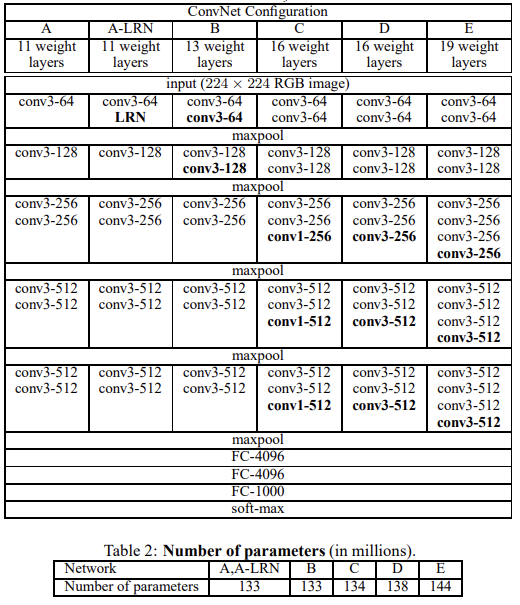  

<h3> <strong> 3. Discussion </strong> </h3>

**(1) 3×3 kernel**

VGG model은 이전 model들과 다르게 stride 1, 3×3 kernel만 사용한다. <br> 
이때 중요한 점은 3×3 filter 2개를 사용하면 5×5 filter를 사용한 것과 동일하며 3개를 사용하면 7×7과 동일한 역할을 하게 된다. <br>
3×3 filter를 사용하면 아래와 같은 이점을 가진다.

* **여러 개의 활성화 함수를 사용할 수 있다.** <br>
5×5 filter를 사용하면 1개의 ReLU만 사용할 수 있지만 3×3 filter는 2개의 ReLU를 사용할 수 있다.
* **parameter를 줄일 수 있다.** <br>
7×7 filter는 $7^2C^2=49C^2$의 파라미터를 가지지만 3개의 3×3 filter는 $3(3^2C^2)=27C^2$개의 파라미터만 계산하면 된다.


**(2) 1×1 conv layer**

VGGNet에서는 비선형성을 부여하기 위해 1×1 conv layer를 사용했다. <br> 입력과 출력의 channel을 동일하게 하고 relu 함수를 거치게 한다.

## <strong> Classification Framwork </strong>

<h3> <strong> 1. Training </strong> </h3>

학습 파라미터는 다음과 같다.

* batch size: 256
* mementum: 0.9
* regularization: L2, weight-decay:0.00005
* learning rate: 0.01, validation accuracy가 개선되지 않으면 10배씩 감소시킨다.

VGGNet은 AlexNet에 비해 더 많은 parameter를 가지지만 다음과 같은 이유로 수렴하기 위해 더 적은 epoch를 요구한다.

* implicit regularisation imposed by greater depth and smaller conv. filter sizes
* pre-initialisation of certain layers

**(1) Pre-Initialisation**

첫 번째 shallow model인 A net을 random initialisation으로 학습시킨다. <br> 
그리고 다른 deep model을 학습할 때는 A net을 이용해 처음 4개의 Conv layer와 마지막 3개의 FC layer를 초기화한다. <br>
단, random initialisation을 수행할 때는 평균이 0이고 분산은 0.01인 normal distribution에서 가져온다. <br> 또한 bias는 0으로 초기화한다. <br>

**(2) Data Augmentation**

Data Augmentation을 위해 다음과 같은 방법을 사용했다.

* **randomly cropped** from rescaled training images (One crop per image per SGD iteration)
* **random horizontal flipping**
* **random RGB colour shift**

**(3) Training image size**

S를 training scale이라고 하자. <br>
논문에서는 S(training scale)를 설정하기 위해 2가지 접근 방식을 사용했다.

첫 번째는 S를 고정하는 **single-scale training**이다. 논문은 실험을 위해 두 가지 scale로 고정했다. (S = 256, 384) <br>
먼저 S = 256을 학습시키고, 학습된 모델의 weight을 이용해 S = 384 model을 초기화시켰다고 한다. <br> 
이때 S = 384 model에는 0.0001 Learning rate를 사용했다고 한다.

두 번째 방식은 **multi-scale training** 방식이다. <br>
각각의 training image는 $[S_{min}, S_{max}]$ 범위 내에서 랜덤으로 선택한 S에 맞게 rescale된다. <br>
논문에서는 $S_{min}=256, S_{max}=512$를 사용했다고 한다. <br>
이미지 안의 물체는 모두 크기가 다르므로 이 방식을 사용하는 것이 효과적이라고 한다. <br>
논문에서는 scale을 무작위로 바꾸며 학습시킨다고 하여 **scale jittering**이라고 표현했다. <br>
학습 속도를 위해 미리 학습된 single scale model(S = 384)과 같은 배치(configuration)인 모든 층들에 fine-tuning을 수행한다. 

정리하자면 학습 데이터를 다양한 크기로 변환하고 일부분을 샘플링하면 다음과 같은 이점을 얻는다.
* scale jittering을 통해 training set augmentation역할을 수행해준다.
* 하나의 오브젝트에 대해 다양한 측면을 학습시 반영시킬 수 있다. <br>
 **변환된 이미지가 작다면 전체적인 측면을 학습하고, 크다면 개체의 특정 부분을 학습할 수 있다.**

<h3> <strong> 2. Testing </strong> </h3>

논문에서 test scale은 Q로 명시하고 있다. <br>
Q는 S와 같을 필요가 없으며 Q에 여러 값을 사용하는 것이 성능 개선에 도움을 주었다. <br>

또한 논문에서는 training 과정에서 사용한 fully-connected layer를 convolutional layer로 변환했다. <br>
**fully-convolutional net을 사용하면 uncropped image가 어떤 크기의 이미지라도 처리할 수 있다.**

* first FC Layer -> 7×7 filter Conv Layer
* Second/Third FC Layer -> 1×1 filter Conv Layer

또한 test set을 horizontal flip시키고 original과 flipped image의 평균을 사용하여 결과를 추론했다.

## <strong> Classification experiments </strong>

<h3> <strong> 1. Single Scale Evaluation </strong> </h3>

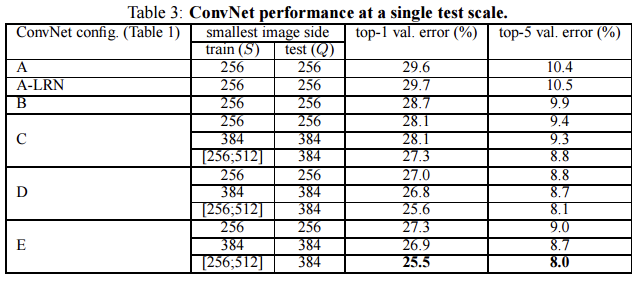

* AlexNet에 사용된 LRN의 효과는 없었다.
* 깊이가 깊어질수록 error가 감소한다.
* C는 B보다 성능이 높고 D보다 성능이 낮다. <br>
이는 추가적인 비선형성이 도움은 되지만 conv filter를 사용해 공간적 맥락을 파악하는 것 역시 중요하다는 것을 보여준다.
* 하지만 Multi-Scale 방식으로 resize한 것이 고정된 scale의 training image보다 성능이 좋았다.

<h3> <strong> 2. Multi-Scale Evaluation </strong> </h3>

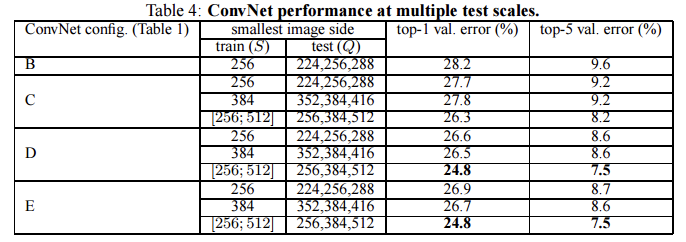

S는 [256, 512] Q는 [256, 384, 512]로 실험했다고 한다. <br>
위처럼 Multi-Scale 방식이 Single-Scale보다 더 성능이 좋았다.

<h3> <strong> 3. Multi-Crop Evaluation </strong> </h3>

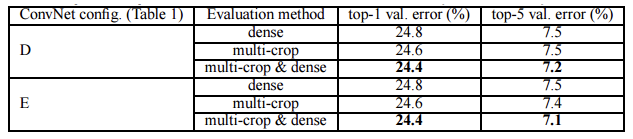

test 이미지를 다양하게 crop을 해주어 더 좋은 성능을 얻었다고 한다.